In [253]:
import os.path
from typing import List
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import date
# from thefuzz import fuzz

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [254]:
RANDOM_STATE = 42

API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.13.453.3037' # '12.12.450.4196''12.13.453.3037' Version 12.12.448.6653 12.11.446.9344 Version 12.13.453.3037 (Jul 11 2022/18:39:20) [PUBLIC] <Releases/12.13>
PATCH: date = date(2022, 7, 16)  # date(2022, 7, 1) date(2022, 7, 16)
THREEDAY: datetime = (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")

TARGETNAME = 'placement'

# Data Loading

In [255]:
# raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{THREEDAY}_matches.pickle'))

# Preprocessing

In [256]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [257]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0          TFT7_Augment_MageConference
augment1           TFT6_Augment_RadiantRelics
augment2           TFT6_Augment_TomeOfTraits1
Set7_Assassin                             0.0
Set7_Astral                               1.0
                             ...             
TFT7_Zoe_item1                           None
TFT7_Zoe_item2                           None
items_count                                13
traits_sum                               10.0
units_sum                                29.0
Name: 4243, Length: 270, dtype: object

In [258]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

matches_df = X.copy()
matches_df[TARGETNAME] = y

# Augments Ranking

## Stage 2-1 augment ranking

In [259]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')
# group and aggregate mean/median
dct = {'Value_Count': ('augment0', 'count'), 'average_placement': ('placement', 'mean')}
augment0_rank_df = m.groupby('augment0', as_index=False).agg(**dct).sort_values(by='average_placement')
augment0_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_34416\207590299.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')


,augment0,Value_Count,average_placement
125,TFT7_Augment_GuildLootHR,2,1.500000
149,TFT7_Augment_Preparation2HR,3,2.666667
135,TFT7_Augment_MageConferenceHR,6,2.833333
176,TFT7_Augment_TempestEmblem2,9,3.444444
156,TFT7_Augment_RevelEmblem2,156,3.512821
131,TFT7_Augment_JadeTrait2,21,3.523810
79,TFT7_Augment_AssassinEmblem2,131,3.648855
116,TFT7_Augment_GadgetExpert,556,3.847122
48,TFT6_Augment_PortableForge,616,3.910714
127,TFT7_Augment_JadeEmblem,89,3.932584


In [260]:
augment0_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment0_ranking.csv'), index=False)

## Stage 3-2 augment ranking

In [261]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')
# group and aggregate mean/median
dct = {'Value_Count': ('augment1', 'count'), 'average_placement': ('placement', 'mean')}
augment1_rank_df = m.groupby('augment1', as_index=False).agg(**dct).sort_values(by='average_placement')
augment1_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_34416\1890264867.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')


,augment1,Value_Count,average_placement
65,TFT6_Augment_Traitless1,29,2.551724
156,TFT7_Augment_RevelEmblem2,34,2.852941
131,TFT7_Augment_JadeTrait2,13,2.923077
70,TFT6_Augment_TriForce3,21,3.142857
129,TFT7_Augment_JadePenitence,10,3.300000
161,TFT7_Augment_ScalescornEmblem2,31,3.322581
163,TFT7_Augment_ShapeshifterBeastsDen,53,3.490566
67,TFT6_Augment_Traitless3,13,3.538462
77,TFT7_Augment_AssassinEmblem,33,3.575758
69,TFT6_Augment_TriForce2,39,3.615385


In [262]:
augment1_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment1_ranking.csv'), index=False)

## Stage 4-2 augment ranking

In [263]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')
# group and aggregate mean/median
dct = {'Value_Count': ('augment2', 'count'), 'average_placement': ('placement', 'mean')}
augment2_rank_df = m.groupby('augment2', as_index=False).agg(**dct).sort_values(by='average_placement')
augment2_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_34416\3922423790.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')


,augment2,Value_Count,average_placement
58,TFT6_Augment_Traitless3,5,1.400000
56,TFT6_Augment_Traitless1,1,2.000000
57,TFT6_Augment_Traitless2,19,2.263158
26,TFT6_Augment_Featherweights3,1,3.000000
148,TFT7_Augment_ShimmerscaleTrait2,9,3.111111
113,TFT7_Augment_JadeEmblem,16,3.250000
59,TFT6_Augment_TriForce1,3,3.333333
68,TFT7_Augment_AssassinTrait,18,3.500000
106,TFT7_Augment_GuardianEmblem2,6,3.500000
153,TFT7_Augment_TempestEmblem,13,3.538462


In [264]:
augment2_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment2_ranking.csv'), index=False)

# Items Ranking

In [265]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [266]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,6.5


In [267]:
# Get top5 value_count >= 12
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [268]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [269]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_top5_items.csv'), index=False)

## Top 1 items

In [270]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, None",27654,4.491972
2,TFT7_Anivia,"ArchangelsStaff, Morellonomicon, SpearOfShojin",20,4.100000
7,TFT7_AoShin,"ArchangelsStaff, Quicksilver, SpearOfShojin",19,2.368421
12,TFT7_Ashe,"Chalice, None, None",16,3.187500
17,TFT7_AurelionSol,"HextechGunblade, MageEmblemItem, SpearOfShojin",19,3.789474
22,TFT7_Bard,"GuardianAngel, None, None",28,2.678571
27,TFT7_Braum,"BrambleVest, None, None",34,3.794118
32,TFT7_Corki,"GuinsoosRageblade, StatikkShiv, StatikkShiv",18,3.333333
37,TFT7_Diana,"FrozenHeart, RedBuff, StatikkShiv",14,2.285714
42,TFT7_DragonBlue,"RevelEmblemItem, StatikkShiv, UnstableConcoction",12,2.750000


# Load TFT asset

In [271]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [272]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [273]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [274]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [275]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [276]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [277]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [278]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Whs-Brr-Drn-DragonPurple,Whs-Shr-Elise,Jae-Shr-Gnar,Jae-Shr-Neeko,Asl-Shr-Nidalee,Asl-Brr-Skarner,Whs-Mae-Brr-Sylas",1,1.0
1,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,She-Drn-Gun-DragonGold,Whs-Brr-Drn-DragonPurple,Whs-Gun-Thresh,Mie-Drr-War-Yasuo",1,1.0
2,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,She-Drn-Gun-DragonGold,Whs-Brr-Drn-DragonPurple,Whs-Asn-Pyke,Whs-Gun-Thresh",1,1.0
3,"Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.0
4,"Rag-Car-Hecarim,Mie-Gun-Leona,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Scn-Brr-War-Olaf,Rag-Brr-War-Shen,Rag-Swt-Xayah,Mie-Drr-War-Yasuo,Mie-War-Yone",1,1.0
...,...,...,...
13226,"Scn-Gun-Braum,Mie-Gun-Leona,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Scn-Brr-War-Olaf,Rag-Brr-War-Shen,Mie-Drr-War-Yasuo,Mie-War-Yone",1,8.0
13227,"Scn-Gun-Braum,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Gud-Car-Sejuani,Asl-Mae-Vladimir,Mie-Drr-War-Yasuo,Mie-War-Yone",1,8.0
13228,"Scn-Gun-Braum,Rag-Car-Hecarim,Mie-Gun-Leona,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Gud-Car-Sejuani,Mie-War-Yone",1,8.0
13229,"Scn-Gun-Braum,Mie-Gun-Leona,Gud-Mae-Ryze,Rag-Brr-War-Shen,Trr-Car-Tristana",1,8.0


In [279]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [280]:
# from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [281]:
# corpus_sentences = list(comp_ranking_df['comp'])

# corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [282]:
# clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
# predict=clustering_model.fit_predict(corpus_embeddings)
# comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [283]:
# comp_ranking_df.sort_values(by='group')

In [284]:
# comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
# comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [285]:
# comp_ranking_df.sort_values(by='group')[:60]

In [286]:
# top5_comp_ranking_list = []
# m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
# top5_comp_ranking_list.extend(m.values)
# top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [287]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

# top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [288]:
# top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
# top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

In [289]:
# comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
# comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_comp_ranking.csv'), index=False)

In [290]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [291]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [292]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [293]:
composition_ranking_df

,comp,value_count,average_placement
0,"Whs-Brr-Drn-DragonPurple,Whs-Shr-Elise,Jae-Shr-Gnar,Jae-Shr-Neeko,Asl-Shr-Nidalee,Asl-Brr-Skarner,Whs-Mae-Brr-Sylas",1,1.0
1,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,She-Drn-Gun-DragonGold,Whs-Brr-Drn-DragonPurple,Whs-Gun-Thresh,Mie-Drr-War-Yasuo",1,1.0
2,"Gud-Myc-Bad-Bard,Mie-Drn-DragonBlue,She-Drn-Gun-DragonGold,Whs-Brr-Drn-DragonPurple,Whs-Asn-Pyke,Whs-Gun-Thresh",1,1.0
3,"Rag-Car-Hecarim,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Gud-Asn-Talon,Gud-Swt-Twitch,Rag-Swt-Xayah,Mie-Drr-War-Yasuo",1,1.0
4,"Rag-Car-Hecarim,Mie-Gun-Leona,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Scn-Brr-War-Olaf,Rag-Brr-War-Shen,Rag-Swt-Xayah,Mie-Drr-War-Yasuo,Mie-War-Yone",1,1.0
...,...,...,...
13226,"Scn-Gun-Braum,Mie-Gun-Leona,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Scn-Brr-War-Olaf,Rag-Brr-War-Shen,Mie-Drr-War-Yasuo,Mie-War-Yone",1,8.0
13227,"Scn-Gun-Braum,Rag-Car-Hecarim,Mie-Gun-Leona,Mie-Car-Nunu,Gud-Car-Sejuani,Asl-Mae-Vladimir,Mie-Drr-War-Yasuo,Mie-War-Yone",1,8.0
13228,"Scn-Gun-Braum,Rag-Car-Hecarim,Mie-Gun-Leona,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Gud-Car-Sejuani,Mie-War-Yone",1,8.0
13229,"Scn-Gun-Braum,Mie-Gun-Leona,Gud-Mae-Ryze,Rag-Brr-War-Shen,Trr-Car-Tristana",1,8.0


# KMode
using - comp string

In [294]:
# # Elbow curve to find optimal K
# cost = []
# K = range(5,30,5)
# for num_clusters in list(K):
#     kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
#     kmode.fit_predict(composition_ranking_df)
#     cost.append(kmode.cost_)
    
# plt.plot(K, cost, 'bx-')
# plt.xlabel('No. of clusters')
# plt.ylabel('Cost')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [295]:
# # Building the model with 3 clusters
# kmode = KModes(n_clusters=15, init = "random", n_init = 5, verbose=1)
# clusters = kmode.fit_predict(composition_ranking_df)
# clusters

In [296]:
# kmode_ranking_df = composition_ranking_df.copy()
# kmode_ranking_df.insert(0, "group", clusters, True)

In [297]:
# kmode_ranking_df

In [298]:
# kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
# kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [299]:
# top5_comp_ranking_list = []
# m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
# top5_comp_ranking_list.extend(m.values)
# top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [300]:
# kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
# kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
# kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

# _

In [301]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [302]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [303]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
13931,1,0,0,0,2,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
15504,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15498,1,0,0,1,0,0,2,0,0,0,...,0,0,0,1,0,0,2,1,0,0
15490,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,2
15481,1,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,8,0,0,0,0,0,0,3,1,0,...,0,0,0,0,0,0,0,1,0,0
24730,8,0,0,0,0,0,0,0,2,0,...,0,0,1,0,0,0,0,2,0,0
20450,8,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
892,8,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,2


## KMode
using integers

In [304]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11166, cost: 319363.0
Run 1, iteration: 2/100, moves: 5422, cost: 317530.0
Run 1, iteration: 3/100, moves: 483, cost: 317530.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8494, cost: 320163.0
Run 2, iteration: 2/100, moves: 2432, cost: 319583.0
Run 2, iteration: 3/100, moves: 605, cost: 319108.0
Run 2, iteration: 4/100, moves: 77, cost: 319108.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8856, cost: 327736.0
Run 3, iteration: 2/100, moves: 1122, cost: 327736.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6509, cost: 353486.0
Run 4, iteration: 2/100, moves: 3869, cost: 349049.0
Run 4, iteration: 3/100, moves: 2733, cost: 339984.0
Run 4, iteration: 4/100, moves: 1206, cost: 339

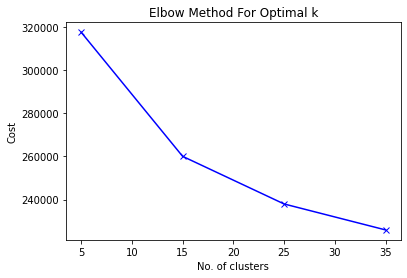

In [305]:
# Elbow curve to find optimal K
cost = []
K = range(5,40,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [306]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7193, cost: 248380.0
Run 1, iteration: 2/100, moves: 3541, cost: 245612.0
Run 1, iteration: 3/100, moves: 1425, cost: 245612.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 10556, cost: 250800.0
Run 2, iteration: 2/100, moves: 5128, cost: 245843.0
Run 2, iteration: 3/100, moves: 1476, cost: 245120.0
Run 2, iteration: 4/100, moves: 161, cost: 244999.0
Run 2, iteration: 5/100, moves: 38, cost: 244999.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8076, cost: 244759.0
Run 3, iteration: 2/100, moves: 2433, cost: 244237.0
Run 3, iteration: 3/100, moves: 326, cost: 244201.0
Run 3, iteration: 4/100, moves: 51, cost: 244201.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10919, cost: 2470

array([ 5, 16, 17, ..., 20,  2,  1], dtype=uint16)

In [307]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [308]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
13931,5,1,0,0,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
15504,16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15498,17,1,0,0,1,0,0,2,0,0,...,0,0,0,1,0,0,2,1,0,0
15490,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,2
15481,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,7,8,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,1,0,0
24730,7,8,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,2,0,0
20450,20,8,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
892,2,8,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,2


In [309]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [310]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [311]:
kmode_ranking_df

,placement,group,comp
18028,5,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
26547,3,0,"DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon, Yasuo"
24356,1,0,"DragonPurple, Elise, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
20265,6,0,"Bard, DragonPurple, Hecarim, Qiyana, Sejuani, Sylas, Talon"
3637,3,0,"Diana, DragonPurple, Kayn, Ornn, Pyke, Qiyana, Talon"
...,...,...,...
9771,2,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah, Yasuo"
4939,4,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
8261,3,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
17176,7,24,"Hecarim, Ornn, Sejuani, Shen, Talon, Twitch, Xayah, Yasuo"


In [312]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [313]:
kmode_ranking_df

,placement,group,comp,grp_count,grp_placement
18028,5,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",1350,4.157778
26547,3,0,"DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon, Yasuo",1350,4.157778
24356,1,0,"DragonPurple, Elise, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",1350,4.157778
20265,6,0,"Bard, DragonPurple, Hecarim, Qiyana, Sejuani, Sylas, Talon",1350,4.157778
3637,3,0,"Diana, DragonPurple, Kayn, Ornn, Pyke, Qiyana, Talon",1350,4.157778
...,...,...,...,...,...
9771,2,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah, Yasuo",1734,4.673010
4939,4,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",1734,4.673010
8261,3,24,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",1734,4.673010
17176,7,24,"Hecarim, Ornn, Sejuani, Shen, Talon, Twitch, Xayah, Yasuo",1734,4.673010


In [314]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['placement', 'group', 'comp', 'grp_count', 'grp_placement'])

In [315]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
25493,8,9,"AoShin, Bard, Hecarim, Ornn, Sejuani, Shen, Talon",818,3.045232,"Bard, Corki, DragonBlue, Jinx, Ornn, Sona, TahmKench, Yasuo"
1520,1,17,"AoShin, Bard, Heimerdinger, Lulu, Nami, Ornn, Soraka, Sylas, TrainerDragon, Zoe",2045,3.266993,"AoShin, Bard, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
7822,1,10,"Bard, Illaoi, Lulu, Nami, Ornn, Qiyana, Talon, Twitch, Varus",745,3.277852,"Bard, Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
7295,2,22,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sona, Sylas, Thresh, TrainerDragon, Zoe",884,3.425339,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe"
84,3,15,"Bard, Corki, DragonPurple, Lulu, Sona, Sylas, TrainerDragon, Tristana",335,3.450746,"Bard, Braum, Corki, Jinx, Lulu, Sona, Thresh, TrainerDragon, Tristana"
4112,7,13,"Bard, Braum, Corki, Jinx, Lulu, Senna, Thresh, TrainerDragon, Tristana",714,3.478992,"Bard, Braum, Corki, DragonGold, Lulu, Sona, TrainerDragon, Tristana"
12757,1,8,"Braum, Diana, Kayn, Lillia, Olaf, Ornn, Qiyana, Talon",1062,3.776836,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
16339,3,5,"DragonPurple, Elise, Gnar, Illaoi, Neeko, Nidalee, Skarner, Sylas",1934,4.010858,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
18028,5,0,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon",1350,4.157778,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
21659,7,12,"DragonBlue, Lillia, Nunu, Sejuani, Soraka, Yasuo, Yone",1308,4.247706,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Yasuo, Yone"


In [316]:
kmode_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmode_comp_ranking.csv'), index=False)

## KMeans

In [317]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

13931    1
15504    1
15498    1
15490    1
15481    1
        ..
16820    8
24730    8
20450    8
892      8
3745     8
Name: placement, Length: 27864, dtype: int64

In [318]:
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
kms = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)

Initialization complete
Iteration 0, inertia 11884.07682247618.
Iteration 1, inertia 7849.622997701282.
Iteration 2, inertia 7597.741751983428.
Iteration 3, inertia 7532.126612899136.
Iteration 4, inertia 7496.418318327015.
Iteration 5, inertia 7476.7619234895465.
Iteration 6, inertia 7463.257973300936.
Iteration 7, inertia 7453.8298929307575.
Iteration 8, inertia 7451.329831204554.
Iteration 9, inertia 7450.284163209684.
Iteration 10, inertia 7449.668262990325.
Iteration 11, inertia 7449.126443923618.
Iteration 12, inertia 7448.639629865036.
Iteration 13, inertia 7448.220662757807.
Iteration 14, inertia 7447.881519862722.
Iteration 15, inertia 7447.359112184779.
Iteration 16, inertia 7446.775821113278.
Iteration 17, inertia 7446.4853739861155.
Iteration 18, inertia 7446.3375617643005.
Iteration 19, inertia 7446.225040449203.
Iteration 20, inertia 7446.128966562837.
Iteration 21, inertia 7445.959594194143.
Iteration 22, inertia 7445.7571478922055.
Iteration 23, inertia 7445.54179456628

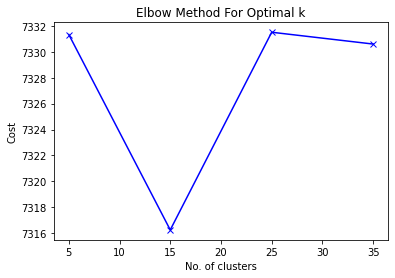

In [319]:
# Elbow curve to find optimal K
cost = []
K = range(5,40,10)
for num_clusters in list(K):
    kmeans.fit_predict(X)
    cost.append(kmeans[-1].inertia_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [320]:
# Building the model with 30 clusters
kms = KMeans(n_clusters=30, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)
clusters = kmeans.fit_predict(X)
clusters

Initialization complete
Iteration 0, inertia 12325.808145803014.
Iteration 1, inertia 8141.12584206604.
Iteration 2, inertia 7887.086279995076.
Iteration 3, inertia 7821.137707681796.
Iteration 4, inertia 7809.482291635995.
Iteration 5, inertia 7802.3857651135995.
Iteration 6, inertia 7796.339427434895.
Iteration 7, inertia 7792.374497581057.
Iteration 8, inertia 7790.845885726386.
Iteration 9, inertia 7789.927643571176.
Iteration 10, inertia 7789.29127461826.
Iteration 11, inertia 7788.590589460132.
Iteration 12, inertia 7787.96832428738.
Iteration 13, inertia 7787.1644863758265.
Iteration 14, inertia 7786.064796011213.
Iteration 15, inertia 7785.0615147356675.
Iteration 16, inertia 7784.245483399928.
Iteration 17, inertia 7783.71683791438.
Iteration 18, inertia 7783.412683673701.
Iteration 19, inertia 7783.248380558379.
Iteration 20, inertia 7783.04042394924.
Iteration 21, inertia 7782.806315378513.
Iteration 22, inertia 7782.41273848422.
Iteration 23, inertia 7781.856137836273.
Iter

array([ 6, 11,  7, ..., 21, 17,  8])

In [321]:
kmeans_ranking_df = units_composition_df.copy()
kmeans_ranking_df.insert(0, "group", clusters, True)

In [322]:
kmeans_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
13931,6,1,0,0,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
15504,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15498,7,1,0,0,1,0,0,2,0,0,...,0,0,0,1,0,0,2,1,0,0
15490,29,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,2
15481,29,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,16,8,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,1,0,0
24730,20,8,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,2,0,0
20450,21,8,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
892,17,8,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,2


In [323]:
kmeans_ranking_df = get_unit_composition_ranking(kmeans_ranking_df, add_trait=False)

In [324]:
kmeans_ranking_df

,placement,group,comp
22389,4,0,"Anivia, Ashe, DragonGreen, Karma, LeeSin, Ornn, Volibear"
5608,5,0,"Ashe, Karma, LeeSin, Neeko, Sett, Swain, Volibear"
12116,2,0,"Ashe, Bard, Hecarim, Karma, LeeSin, Neeko, Nunu, Yasuo"
3108,2,0,"Ashe, Gnar, Karma, LeeSin, Neeko, Ornn, Sett, Shen, Swain"
10334,6,0,"Ashe, Hecarim, Karma, LeeSin, Sett, Swain, Volibear"
...,...,...,...
27710,2,29,"Diana, DragonPurple, Pyke, Qiyana, Sylas, Talon, Thresh"
2290,3,29,"Bard, DragonPurple, Elise, Pyke, Qiyana, Sylas, Talon"
27770,2,29,"DragonPurple, Ornn, Pyke, Qiyana, Sylas, Talon, Thresh"
5019,3,29,"Diana, DragonGold, Pyke, Qiyana, Soraka, Talon, Thresh"


In [325]:
kmeans_ranking_df['grp_count'] = kmeans_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmeans_ranking_df['grp_placement'] = kmeans_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [326]:
kmeans_ranking_df['mode'] = kmeans_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmeans_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
4252,1,7,"AoShin, Heimerdinger, Lulu, Ornn, Ryze, Sona, Sylas, TrainerDragon, Zoe",1544,3.293394,"AoShin, Bard, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Zoe"
17122,3,26,"AoShin, Bard, Lulu, Nami, Ornn, Ryze, Sylas, Zoe",848,3.523585,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Zoe"
8075,4,5,"Diana, Olaf, Ornn, Qiyana, Shen, Sylas, Talon",1238,3.890145,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
924,5,18,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Twitch, Varus",701,4.095578,"Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Twitch, Varus"
4434,1,21,"Corki, Diana, Hecarim, Lulu, Neeko, Ornn, Xayah, Yasuo",357,4.162465,"Corki, Hecarim, Neeko, Ornn, Xayah, Yasuo"
26332,5,6,"Braum, Elise, Gnar, Neeko, Nidalee, Swain, Taric, Thresh",924,4.183983,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
9906,5,29,"Diana, DragonPurple, Kayn, Ornn, Qiyana, Sylas, Talon",693,4.253968,"Diana, DragonPurple, Ornn, Qiyana, Shen, Sylas, Talon"
26535,5,11,"DragonGreen, Ezreal, Illaoi, Nami, Ornn, Varus",1099,4.323931,"Bard, Illaoi, Nami, Ornn, Qiyana, Talon, Twitch, Varus"
23963,4,10,"Anivia, DragonGreen, Gnar, Lulu, Neeko, Sona",920,4.361957,"Anivia, Ashe, DragonGreen, Gnar, Lulu, Neeko, Soraka"
10159,7,17,"DragonPurple, Elise, Neeko, Pyke, Sylas, Thresh",1273,4.490181,"DragonPurple, Elise, Neeko, Soraka, Sylas, Taric, Thresh"


In [327]:
kmeans_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmeans_comp_ranking.csv'), index=False)

## DBSCAN

In [328]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

13931    1
15504    1
15498    1
15490    1
15481    1
        ..
16820    8
24730    8
20450    8
892      8
3745     8
Name: placement, Length: 27864, dtype: int64

In [329]:
units_composition_df.shape

(27864, 88)

In [330]:
# Building the model with 3 clusters
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
dbs= DBSCAN(eps=0.37, metric='euclidean', min_samples=3, n_jobs=-1) #eps=0.053, metric='cosine'
dbscan = make_pipeline(normalizer, dbs)
clusters = dbscan.fit_predict(X)
clusters

array([ 0,  1,  1, ..., -1,  2, -1], dtype=int64)

In [331]:
dbscan_ranking_df = units_composition_df.copy()
dbscan_ranking_df.insert(0, "group", clusters, True)

In [332]:
dbscan_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
13931,0,1,0,0,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
15504,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15498,1,1,0,0,1,0,0,2,0,0,...,0,0,0,1,0,0,2,1,0,0
15490,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,2
15481,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,1,8,0,0,0,0,0,0,3,1,...,0,0,0,0,0,0,0,1,0,0
24730,1,8,0,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,2,0,0
20450,-1,8,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
892,2,8,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,2


In [333]:
dbscan_ranking_df = get_unit_composition_ranking(dbscan_ranking_df, add_trait=False)

In [334]:
dbscan_ranking_df

,placement,group,comp
3745,8,-1,"DragonGold, DragonPurple, Shyvana, Sylas"
24686,5,-1,"Bard, DragonGreen, Hecarim, Ornn, Qiyana, Sejuani, Shen, Twitch, Xayah"
22442,5,-1,"AoShin, Bard, Lulu, Ornn, Ryze, Shen, Sona, Talon"
14935,2,-1,"AoShin, Bard, LeeSin, Nami, Ornn, Soraka, Sylas, Zoe"
24673,5,-1,"DragonBlue, LeeSin, Nunu, Ornn, Sejuani, Shen, Yasuo"
...,...,...,...
7834,8,206,"Corki, DragonGold, Jinx, Sona, Thresh, Tristana"
26838,8,207,"Braum, Corki, DragonGold, Jinx, Sona, Tristana"
11526,7,207,"Braum, Corki, DragonGold, Jinx, Senna, Sona, Tristana"
27220,8,207,"Braum, Corki, DragonGold, Jinx, Sona, Tristana"


In [335]:
dbscan_ranking_df['grp_count'] = dbscan_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
dbscan_ranking_df['grp_placement'] = dbscan_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')
dbscan_ranking_df['mode'] = dbscan_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
dbscan_ranking_df.groupby(['group']).head(1).sort_values(by='grp_count', ascending=False)[:60]

,placement,group,comp,grp_count,grp_placement,mode
3564,1,2,"Braum, Diana, Lillia, Olaf, Sejuani, Shen, Talon, Thresh",9864.0,4.212251,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
2021,8,0,"DragonGreen, Elise, Gnar, Nidalee, Soraka, Swain",7008.0,3.722960,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
19758,6,3,"Bard, DragonBlue, Hecarim, Nunu, Talon, Yasuo, Yone",3967.0,4.417178,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Yasuo, Yone"
7978,2,5,"Ashe, DragonGreen, Ezreal, Karma, LeeSin, Leona, Taric",2957.0,4.510949,"Ashe, DragonGreen, Ezreal, Karma, LeeSin, Leona, Taric"
22752,3,4,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",1141.0,4.560703,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
23396,5,1,"Bard, Illaoi, Nami, Ornn, Ryze, Sylas, Vladimir, Zoe",527.0,4.298966,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir"
17856,2,14,"DragonBlue, Nunu, Ornn, Qiyana, Sejuani, Talon, Yasuo, Yone",482.0,3.333333,"DragonBlue, Leona, Nunu, Ornn, Qiyana, Sejuani, Talon"
14207,1,23,"Braum, Diana, Kayn, Lillia, Olaf, Pyke, Shen, Thresh",311.0,4.333333,"Braum, Diana, Kayn, Lillia, Olaf, Pyke, Shen, Thresh"
9994,4,6,"Corki, Heimerdinger, Lulu, Ornn, Sona, Sylas, TrainerDragon, Tristana, Zoe",137.0,4.038462,"Bard, Corki, Heimerdinger, Lulu, Ornn, Sona, Sylas, TrainerDragon, Zoe"
16614,7,34,"AoShin, Bard, Ornn, Ryze, Sejuani, Shen, Talon",111.0,3.750000,"AoShin, Hecarim, Ornn, Ryze, Sejuani, Talon, Twitch"


In [336]:
dbscan_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_dbscan_comp_ranking.csv'), index=False)